In [1]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from collections import deque, namedtuple
from environment import Model, AdversaryModes

In [2]:
total_demand = 400
agent_cost = 57
adversary_cost = 71 
costs = [agent_cost,adversary_cost]
total_stages = 25
adversary_probabilities=[0]*len(AdversaryModes)
adversary_probabilities[0]=1

env = Model(total_demand, costs, total_stages, adversary_probabilities)
torch.manual_seed(0)

In [3]:
class QNetwork(nn.Module):

    def __init__(self, state_size, action_size):
        super().__init__() 
        self.input_layer = nn.Linear(state_size, 200)
        self.hidden_layer = nn.Linear(200, 200)
        self.output_layer = nn.Linear(200, action_size)
        
    def forward(self, state):
        x = self.input_layer(state)
        x = F.relu(x)
        x = self.hidden_layer(x)
        x = F.relu(x)
        x = self.output_layer(x)
        return x

In [4]:
BUFFER_SIZE = int(10_000)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 1            # discount factor
TAU = 0.001              # for soft update of target parameters
LR = 0.0005               # learning rate 
UPDATE_EVERY = 8        # how often to update the network

In [5]:
class Agent():

    def __init__(self, state_size, action_size):

        self.state_size = state_size
        self.action_size = action_size

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size)
        self.qnetwork_target = QNetwork(state_size, action_size)
        self.optimiser = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE)
        # Initialise time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps):

        state = state.float().unsqueeze(0)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):

        states, actions, rewards, next_states, dones = experiences
        q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        q_targets = rewards + gamma * q_targets_next * (1 - dones)
        q_expected = self.qnetwork_local(states).gather(1, actions)
        
        loss = F.mse_loss(q_expected, q_targets)
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [6]:
class ReplayBuffer:

    def __init__(self, action_size, buffer_size, batch_size):

        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        experience = self.experience(state, action, reward, next_state, done)
        self.memory.append(experience)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([experience.state for experience in experiences if experience is not None])).float()
        actions = torch.from_numpy(np.vstack([experience.action for experience in experiences if experience is not None])).long()
        rewards = torch.from_numpy(np.vstack([experience.reward for experience in experiences if experience is not None])).float()
        next_states = torch.from_numpy(np.vstack([experience.next_state for experience in experiences if experience is not None])).float()
        dones = torch.from_numpy(np.vstack([experience.done for experience in experiences if experience is not None]).astype(np.uint8)).float()
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [7]:
def dqn(number_episodes, eps_start=1.0, eps_end=0.0001, eps_decay=0.99995):

    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialise epsilon
    best_payoff = 0
    best_actions = list()
    for episode in range(number_episodes):
        state, reward, done = env.reset()
        score = 0
        actions = list()
        while not done:
            action = agent.act(state, eps)
            actions.append(action)
            next_state, reward, done = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        if score >= best_payoff:
            best_payoff = score
            best_actions = actions
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_window)), end="")
        if episode % 5000 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_window)))
    return scores, best_payoff, best_actions

agent = Agent(state_size=2, action_size=60)
scores, best_payoff, best_actions = dqn(200_000)

Episode 0	Average Score: 169671.00
Episode 5000	Average Score: 165271.83
Episode 10000	Average Score: 165782.55
Episode 15000	Average Score: 166931.08
Episode 20000	Average Score: 167496.04
Episode 25000	Average Score: 169142.78
Episode 30000	Average Score: 171067.50
Episode 35000	Average Score: 171962.95
Episode 40000	Average Score: 172211.15
Episode 45000	Average Score: 172176.92
Episode 50000	Average Score: 173292.13
Episode 55000	Average Score: 174271.68
Episode 60000	Average Score: 176350.42
Episode 65000	Average Score: 177105.63
Episode 70000	Average Score: 178208.86
Episode 75000	Average Score: 177706.84
Episode 80000	Average Score: 177841.97
Episode 85000	Average Score: 176620.66
Episode 90000	Average Score: 177956.96
Episode 95000	Average Score: 177746.00
Episode 100000	Average Score: 178210.52
Episode 105000	Average Score: 177339.47
Episode 110000	Average Score: 177947.92
Episode 115000	Average Score: 177841.17
Episode 120000	Average Score: 177980.15
Episode 125000	Average Sc

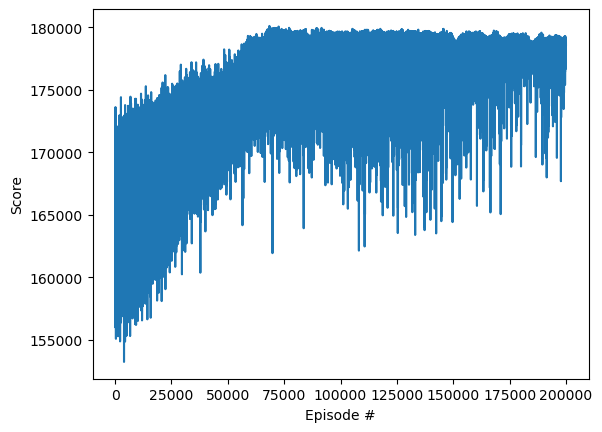

In [8]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [9]:
best_payoff

180121

In [10]:
np.transpose(best_actions)

array([48, 52, 52, 52, 52, 50, 50, 50, 50, 50, 50, 50, 50, 50, 46, 46, 46,
       46, 46, 46, 46, 46, 46, 20,  4])

In [12]:
np.mean(scores[190_000:199_999])

177990.99859985997

In [11]:
np.std(scores[190_000:199_999])

925.9989800259722